In [10]:
%matplotlib inline

from collections import defaultdict as ddict, OrderedDict as odict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc
import copy
from sklearn.model_selection import train_test_split
import imp
import umap
import umap.plot
import sklearn.decomposition as decomp
from sklearn.preprocessing import StandardScaler

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation

In [16]:
from modules.data import data_maker
from modules.RNN import double_RNN
from modules.fit import Model, fit, predict, mae, rmse, load_exp
from modules.data import pka_scaler, double_loader, collate_double, sentence_dataset
from modules.myhyperopt import hyperopt_func
from modules.MPNN import double_MPNN

In [5]:
data = pd.read_csv('data/full_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
data_size = len(solute)

sol_set = list(set(solute))
solv_set = list(set(solvent))

In [13]:
indices = list(range(data_size))
CV_ids, holdout_ids, _, _ = train_test_split(indices, solvent, test_size=0.2, random_state=1, stratify=solvent)
datasets = data_maker(solute, solvent, pka)

In [11]:
DMPNN = Model(name='D-MPNN',
              model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='ReLU', 
                                atom_messages=False, dropout=0, interaction=None, readout='sum'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
DMPNN_att = Model(name='D-MPNN with attention',
              model=double_MPNN(MP_depth=4, MP_hidden=128, NN_depth=4, NN_hidden=64, activation='ELU', 
                                atom_messages=False, dropout=0, interaction='tanh', readout='mean'),
              lr=0.001,
              batch_size=64,
              model_type='torch',
              data_type='graphs')
MPNN = Model(name='MPNN',
             model=double_MPNN(MP_depth=3, MP_hidden=256, NN_depth=2, NN_hidden=512, activation='LeakyReLU', 
                                  atom_messages=True, dropout=0, interaction=None, readout='sum'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
MPNN_att = Model(name='MPNN with attention',
             model=double_MPNN(MP_depth=2, MP_hidden=64, NN_depth=4, NN_hidden=512, activation='ReLU', 
                                  atom_messages=True, dropout=0, interaction='tanh', readout='max'),
             lr=0.001,
             batch_size=64,
             model_type='torch',
             data_type='graphs')
RNN = Model(name='RNN',
            model=double_RNN(NN_depth=3, NN_hidden=512, RNN_hidden=512, activation='ReLU', dropout=0.3,
                             features=300, interaction=None, readout='max'),
            lr=0.001,
            batch_size=32,
            model_type='torch',
            data_type='sentences')
RNN_att = Model(name='RNN with attention',
                model=double_RNN(NN_depth=1, NN_hidden=1024, RNN_hidden=512, activation='PReLU', dropout=0.1,
                                 features=300, interaction='exp', readout='max'),
                lr=0.001,
                batch_size=32,
                model_type='torch',
                data_type='sentences')
RF_desc = Model(name='Random forest with descriptors',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='descriptors')
RF_ECFP = Model(name='Random forest with ECFP',
                model=RandomForestRegressor(bootstrap=True, max_depth=512, max_features='auto', min_samples_leaf=2, min_samples_split=2, n_estimators=2048, n_jobs=-1),
                model_type='sklearn',
                data_type='ECFP')
MLP_desc = Model(name='MLP with descriptors',
                 model=MLPRegressor(activation='logistic', batch_size=32, early_stopping=True, hidden_layer_sizes=(512, 256, 128), solver='adam'),
                 model_type='sklearn',
                 data_type='descriptors')
MLP_ECFP = Model(name='MLP with ECFP',
                 model=MLPRegressor(activation='relu', batch_size=16, early_stopping=True, hidden_layer_sizes=(256, 128, 64), solver='adam'),
                 model_type='sklearn',
                 data_type='ECFP')
XGB_desc = Model(name='XGBoost with descriptors',
                 model=XGBRegressor(colsample_bytree=0.7, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.9),
                 model_type='sklearn',
                 data_type='descriptors')
XGB_ECFP = Model(name='XGBoost with ECFP',
                 model=XGBRegressor(colsample_bytree=0.6, eta=0.1, gamma=0, max_depth=8, min_child_weight=2, n_estimators=2048, n_jobs=-1, subsample=0.8),
                 model_type='sklearn',
                 data_type='ECFP')
#list of all models for testing
#models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att, RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]
DL_models = [DMPNN, DMPNN_att, MPNN, MPNN_att, RNN, RNN_att]
models = [RF_desc, RF_ECFP, MLP_desc, MLP_ECFP, XGB_desc, XGB_ECFP]

In [14]:
#loading models
for m in DL_models:
    data = datasets[m.data_type]
    load_exp(m, "Holdout test", data, CV_ids)

---
## Feature importance

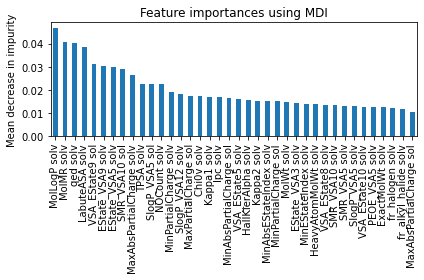

In [27]:
#feature importance for descriptor models
exp = RF_desc.experiments["Holdout test"]["model"]

featuriser = dc.feat.RDKitDescriptors()
sol = featuriser.featurize('CC')
features = featuriser.descriptors
sol_features = [feat+' sol' for feat in features]
solv_features = [feat+' solv' for feat in features]
feature_names = sol_features+solv_features

forest_importances = pd.Series(exp.feature_importances_, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)
tops = forest_importances[forest_importances > 0.01]

fig, ax = plt.subplots()
tops.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

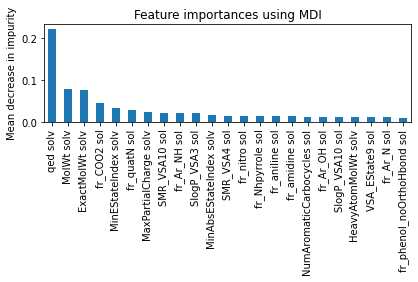

In [29]:
exp = XGB_desc.experiments["Holdout test"]["model"]

forest_importances = pd.Series(exp.feature_importances_, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)
tops = forest_importances[forest_importances > 0.01]

fig, ax = plt.subplots()
tops.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

---
## Attention layer analysis

---
## Learned feature latent space

In [17]:
#solute descriptors
featurizer = dc.feat.RDKitDescriptors()
sol_desc = featurizer.featurize(sol_set)
sol_desc = StandardScaler().fit_transform(sol_desc)

#solute mol2vec
sentence_sol = sentence_dataset(sol_set)
vec_sol = [torch.sum(sen, dim=0) for sen in sentence_sol]
vec_sol = np.array([t.detach().numpy() for t in vec_sol])
vec_sol = StandardScaler().fit_transform(vec_sol)

features = {'Descriptors':sol_desc, 'mol2vec':vec_sol}

In [18]:
fake_solv = ['O' for sol in sol_set]
fake_pka = [0 for sol in sol_set]
sol_datasets = data_maker(sol_set, fake_solv, fake_pka)

In [28]:
ids = list(range(len(sol_set)))
for m in DL_models:
    model = m.experiments["Holdout test"]["model"]
    data = sol_datasets[m.data_type]
    loader = double_loader(data, ids, batch_size=len(ids))
    for (sol,solv,targets) in loader:
        outputs = model.features(sol,solv)
        outputs = outputs[0].detach().numpy()
    features[m.name] = outputs

TypeError: 'int' object is not callable

Descriptors


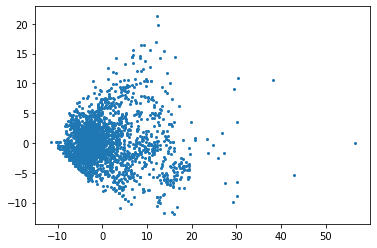

mol2vec


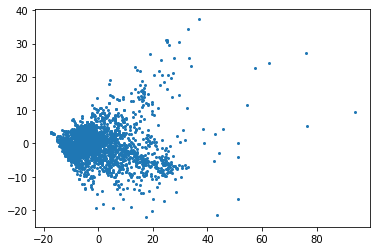

D-MPNN


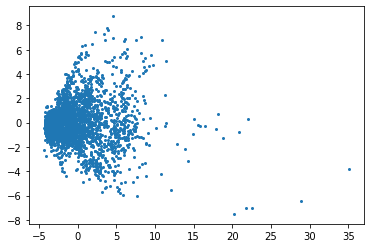

D-MPNN with attention


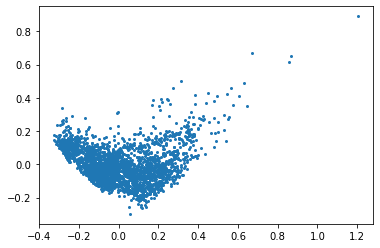

MPNN


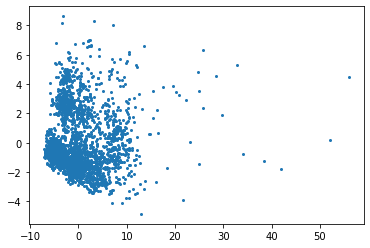

MPNN with attention


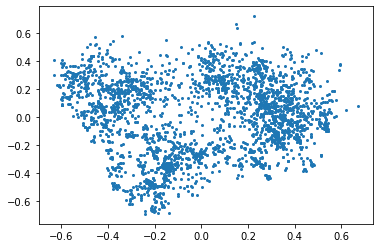

In [34]:
#PCA
PCA_func = decomp.PCA(n_components=2)

for name, d in features.items():
    print(name)
    sol_PCA = PCA_func.fit_transform(d)
    plt.plot(sol_PCA[:,0], sol_PCA[:,1],'o', markersize=2)
    plt.show()

Descriptors


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


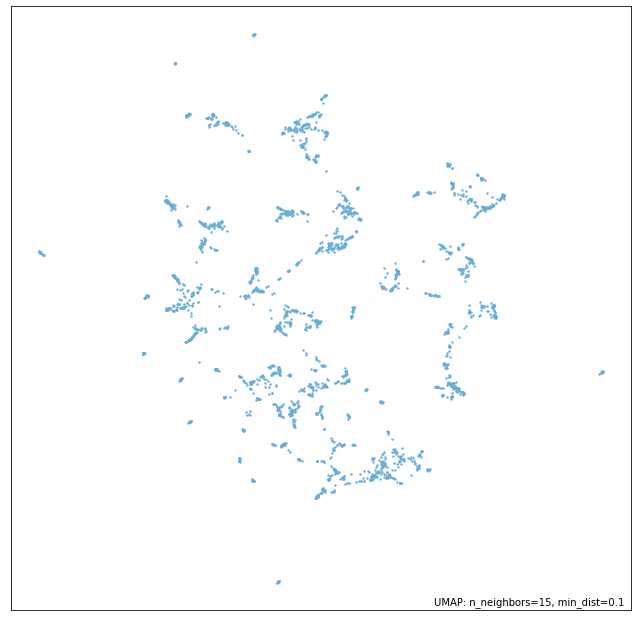

mol2vec


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


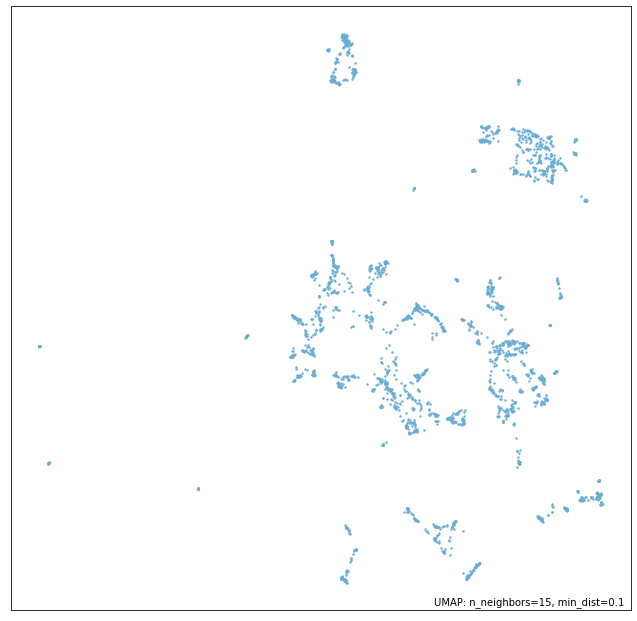

D-MPNN


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


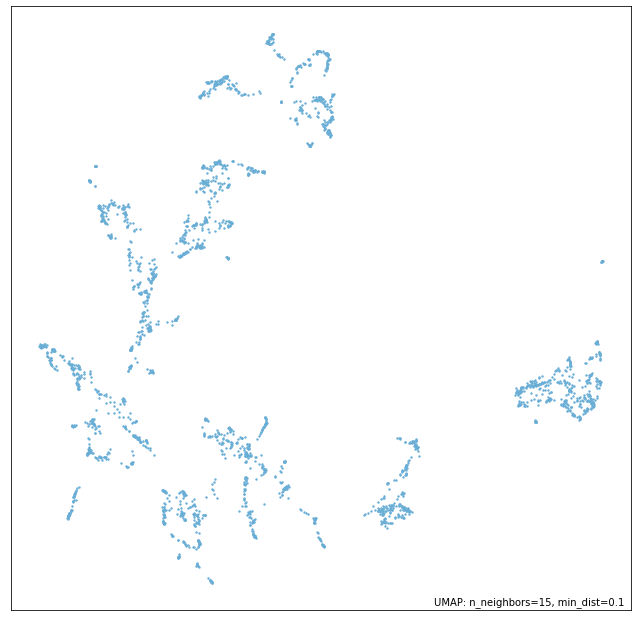

D-MPNN with attention


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


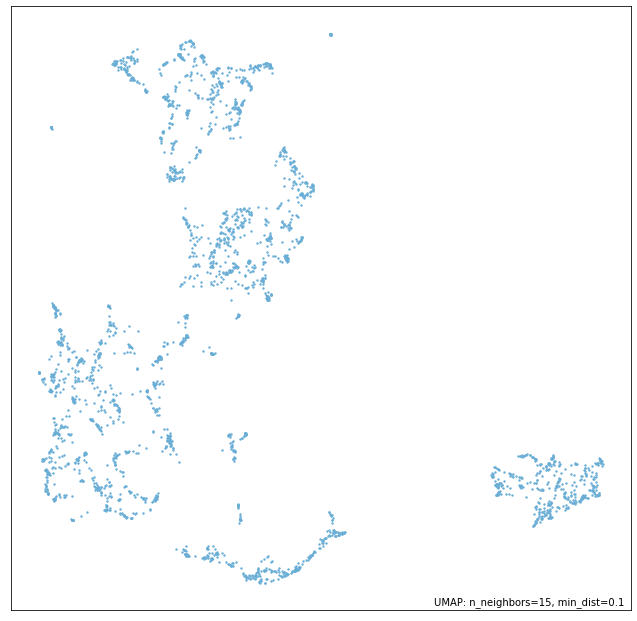

MPNN


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


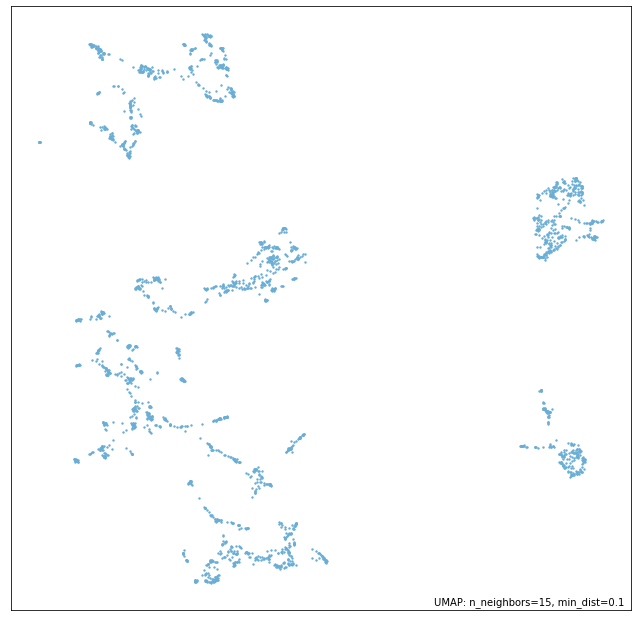

MPNN with attention


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


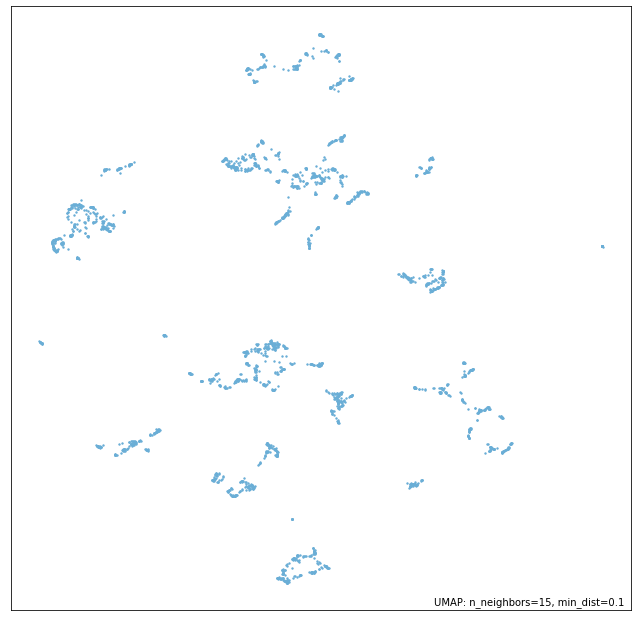

In [36]:
#UMAP
for name, d in features.items():
    print(name)
    mapper = umap.UMAP().fit(d)
#    umap.plot.diagnostic(mapper, diagnostic_type='local_dim')
#    plt.show()
    umap.plot.points(mapper)
    plt.show()